In [1]:
import pandas as pd
import time
import random
import math
import mmh3
from statistics import mean

# Teste de tempo de permancia dos blocos: usando descarte

In [3]:
def str_to_MinHash(str1, q, seed=0):
    return min([mmh3.hash(str1[i:i + q], seed) for i in range(len(str1) - q + 1)])

def frequent2(temp, L, t):
    return {k: v for (k, v) in temp.items() if v/L >= t}

def matching():
    global tp, fp, pairsNo, L1, q
    for index2 in range(nbS, nbS + offsetB): 
        if index2 > len(df2) - 1:
            return True

        rr = df2.iloc[index2, 0:5]
        idScholar = rr["id"]
        title = rr["title"]
        authors = rr["authors"]
        srec = title + " " + authors

        temp = dict()
        indices = [random.randrange(0, L) for i in range(L1)]
        matchingPairs = {}
        for l in indices:
            key = str(str_to_MinHash(srec.lower(), q, l))
            d = dictB[l]
            if key in d:
                ids = d[key]
                for id in ids:
                    if id in temp:
                        temp[id] += 1
                        if temp[id] / L1 >= t:
                            matchingPairs[id] = 1
                    else:
                        temp[id] = 1
        for id in matchingPairs.keys():
            idDBLP = id
            pairsNo += 1
            if idDBLP in truthD:
                ids = truthD[idDBLP]
                for id in ids:
                    if id == idScholar:
                        tp += 1
                        break
            else:
                fp += 1

    return False


def elimina_elementos_dentro_dictB(array_para_descarte, array_para_descarte_igual, elementos_para_descarte):
    indice = 0
    for (tempo_inserido) in array_para_descarte_igual:
        if tempo_inserido < elementos_para_descarte:
            indice += 1
        else:
            del array_para_descarte[:indice]
            del array_para_descarte_igual[:indice]
            break



In [99]:
df1 = pd.read_csv("../00-datasets/DBLP.csv", sep=",", encoding="utf-8", keep_default_na=False)
df2 = pd.read_csv("../00-datasets/Scholar.csv", sep=",", encoding="utf-8", keep_default_na=False)
truth = pd.read_csv("../00-datasets/truth.csv", sep=",", encoding="utf-8", keep_default_na=False)
truthD = dict()
for i, r in truth.iterrows():
    idDBLP = r["idDBLP"]
    idScholar = r["idScholar"]
    if idDBLP in truthD:
        ids = truthD[idDBLP]
        ids.append(idScholar)
    else:
        truthD[idDBLP] = [idScholar]

t = 0.5
TP = 5347
eps = 0.1
w = 1000
delta = 0.1
L = math.ceil(math.log(1 / delta) / (2 * (eps ** 2)))
eps = 0.01
L1 = int(1 / (2 * eps))
print("L=", L, "L1=", L1)
q = 2
dictB = [dict() for l in range(L)]
dictB_igual = [dict() for l in range(L)]
tp = 0
fp = 0
pairsNo = 0
nbS = 1
naS = 1
offsetA = 50
offsetB = 50
blockingTime = 0
matchingTime = 0


tempoQueFoiInseridoNaEstrutura = 0 # esse é o valor que sera colocado junto com o id, seria a posiçaõ do elemento no array
elementos_para_descarte = 50 # esse é a quantidade de elementos que serão descartados
acompanhamentoIndicePorBloco = {} #essa estrutura é um indice que vai ser usada para saber qual a posição do elemento que será descartado
tamanhoDosBlocos = {}

L= 116 L1= 50


In [ ]:
def exclui_blocos(dictB, dictB_igual, tempoQueFoiInseridoNaEstrutura,tamanhoDosBlocos):
    for l, blocos_da_pos in enumerate(dictB_igual):
        for key, bloco_unico in blocos_da_pos.items():
            if bloco_unico[-1] < tempoQueFoiInseridoNaEstrutura - 300 and tamanhoDosBlocos[(key, l)] > 100:
                tamanhoDosBlocos[(key, l)] -= 100
            break

In [100]:
while True:
    st = time.time()
    for index1 in range(naS, naS + offsetA):
        if index1 >= len(df1):
            break
        rr = df1.iloc[index1, 0:5]
        idDBLP = rr["id"]
        title = rr["title"]
        authors = rr["authors"]

        srec = title + " " + authors
        key = ""
        
        for l in range(L):
            key = str(str_to_MinHash(srec.lower(), 2, l))
            d = dictB[l]
            d_igual = dictB_igual[l]
            if key in d:
                ids = d[key]
                ids_igual = d_igual[key]
                tamanho_atual = tamanhoDosBlocos[(key, l)]
                if len(ids) < tamanho_atual:
                    ids.append(idDBLP)
                    ids_igual.append(tempoQueFoiInseridoNaEstrutura)
                else:
                    qtd_descarte, elementoAtualParaDescarte = acompanhamentoIndicePorBloco[(key, l)]
                    elimina_elementos_dentro_dictB(ids, ids_igual, elementoAtualParaDescarte)
                    acompanhamentoIndicePorBloco[(key, l)] = [qtd_descarte + 1, elementoAtualParaDescarte + elementos_para_descarte ]
                    ids.append(idDBLP)
                    ids_igual.append(tempoQueFoiInseridoNaEstrutura)
                    exclui_blocos(dictB, dictB_igual, tempoQueFoiInseridoNaEstrutura, tamanhoDosBlocos)
                    tamanhoDosBlocos[(key, l)] += 100
                    
            else:
                d[key] = [idDBLP]
                d_igual[key] = [tempoQueFoiInseridoNaEstrutura]
                acompanhamentoIndicePorBloco[(key, l)] = [0, elementos_para_descarte,]
                tamanhoDosBlocos[(key, l)] = w
            

        tempoQueFoiInseridoNaEstrutura += 1
    
    end = time.time()

    blockingTime += (end - st)
    st = time.time()
    termination = matching()  
    end = time.time()
    matchingTime += (end - st)
    if termination:
            break

    nbS += offsetB
    naS += offsetA

print("blocking time (in mins)", blockingTime / 60)
print("matching time (in mins)", matchingTime / 60)
if tp + fp > 0:
    print("TP=", tp, "Recall=", tp / TP, "Precision=", tp / (tp + fp), "pairsNo=", pairsNo)

bloco: 824
ultimo valor do bloco: 824 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 0
ultimo valor do bloco: 0 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 837
ultimo valor do bloco: 837 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 952
ultimo valor do bloco: 952 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 156
ultimo valor do bloco: 156 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 1016
ultimo valor do bloco: 1016 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 952
ultimo valor do bloco: 952 tempo atual de inserção 1482
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido
bloco: 4

In [101]:
mean(tamanhoDosBlocos.values())

998.3518086347725

In [133]:
plotar_valores = (tamanhoDosBlocos.values())

In [134]:
plotar_valores = [x for x in plotar_valores if x != 1000]
plotar_valores

[1100,
 100,
 100,
 100,
 1400,
 1100,
 700,
 100,
 100,
 100,
 100,
 500,
 100,
 1100,
 100,
 1500,
 100,
 400,
 1400,
 100,
 1100,
 1200,
 1100,
 1200,
 100,
 100,
 100,
 1300,
 100,
 900,
 100,
 400,
 100,
 1100,
 100,
 100,
 100,
 1200,
 100,
 1700,
 1100,
 1200,
 1200,
 1500,
 1300,
 1400,
 1200,
 1200,
 1200,
 1400,
 1300,
 1400,
 1200,
 1300,
 1100,
 1600,
 1400,
 1100,
 1100,
 1200,
 1300,
 1100,
 1100,
 1100,
 1200]

In [136]:
dados = Counter(plotar_valores)
dados

Counter({100: 21,
         1100: 13,
         1200: 11,
         1400: 6,
         1300: 5,
         1500: 2,
         400: 2,
         700: 1,
         500: 1,
         900: 1,
         1700: 1,
         1600: 1})

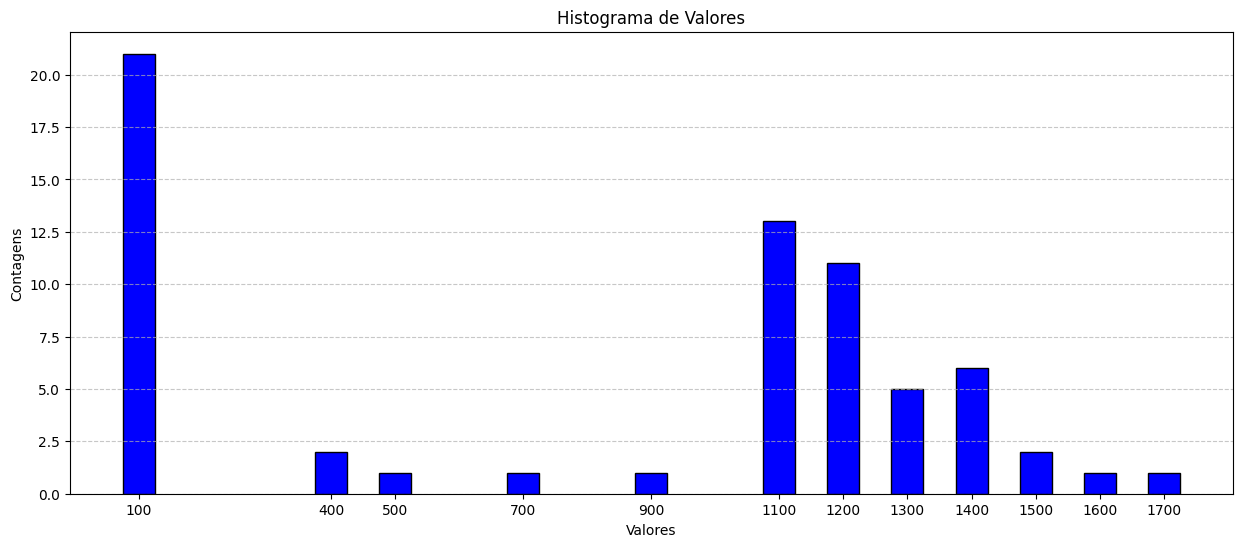

In [137]:
import matplotlib.pyplot as plt
from collections import Counter

# Contar as ocorrências de cada número
dados = Counter(plotar_valores)

# Separar as chaves e valores
valores = list(dados.keys())
contagens = list(dados.values())

# Ajustar o tamanho do gráfico
plt.figure(figsize=(15, 6))

# Plotar o histograma
plt.bar(valores, contagens, width= 50, color='blue', edgecolor='black')

# Adicionar rótulos, título e grades
plt.xlabel('Valores')
plt.ylabel('Contagens')
plt.title('Histograma de Valores')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.xticks(valores)
plt.show()

In [70]:
dictB_igual

[{'-2053413593': [0,
   19,
   38,
   39,
   50,
   65,
   66,
   70,
   79,
   88,
   107,
   156,
   157,
   162,
   214,
   230,
   234,
   256,
   257,
   259,
   284,
   306,
   366,
   384,
   387,
   390,
   394,
   396,
   398,
   408,
   412,
   426,
   429,
   448,
   452,
   454,
   458,
   464,
   466,
   500,
   510,
   529,
   534,
   544,
   556,
   577,
   583,
   609,
   632,
   651,
   659,
   671,
   678,
   687,
   728,
   740,
   766,
   767,
   790,
   802,
   809,
   819,
   824,
   825,
   828,
   845,
   849,
   852,
   856,
   860,
   863,
   865,
   872,
   879,
   885,
   886,
   902,
   904,
   905,
   907,
   909,
   913,
   914,
   920,
   927,
   931,
   938,
   944,
   954,
   956,
   961,
   962,
   966,
   993,
   997,
   1003,
   1008,
   1022,
   1070,
   1089,
   1090,
   1095,
   1114,
   1119,
   1138,
   1149,
   1154,
   1156,
   1168,
   1169,
   1171,
   1181,
   1183,
   1190,
   1193,
   1209,
   1213,
   1222,
   1239,
   1270,
   1282,
  

In [ ]:
def exclui_blocos(dictB, dictB_igual, tempoQueFoiInseridoNaEstrutura,tamanhoDosBlocos):
    for l, blocos_da_pos in enumerate(dictB_igual):
        for key, bloco_unico in blocos_da_pos.items():
            if bloco_unico[-1] < tempoQueFoiInseridoNaEstrutura - 1:
                print("bloco:", bloco_unico[-1])
                print("ultimo valor do bloco:", bloco_unico[-1], "tempo atual de inserção", tempoQueFoiInseridoNaEstrutura)
                print("vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido")
                tamanhoDosBlocos[(key, l)] -= 100
            break

exclui_blocos(dictB, dictB_igual, 100, w)


bloco: 0
ultimo valor do bloco: 0 tempo atual de inserção 100
vai eliminar um bloco aqui, pois esse bloco faz mto tempo que foi inserido


TypeError: 'int' object is not subscriptable

In [8]:
acompanhamentoIndicePorBloco

{('-2053413593', 0): [0, 50],
 ('-2133641798', 1): [1, 100],
 ('-2070745776', 2): [0, 50],
 ('-2145163738', 3): [0, 50],
 ('-2099805373', 4): [0, 50],
 ('-2013476183', 5): [0, 50],
 ('-2092373245', 6): [0, 50],
 ('-2025556504', 7): [0, 50],
 ('-2117495091', 8): [0, 50],
 ('-2123832401', 9): [0, 50],
 ('-2054819018', 10): [0, 50],
 ('-2080595683', 11): [0, 50],
 ('-2023351694', 12): [0, 50],
 ('-2074731222', 13): [0, 50],
 ('-1886976138', 14): [0, 50],
 ('-2146285327', 15): [0, 50],
 ('-1952114201', 16): [0, 50],
 ('-2065811062', 17): [0, 50],
 ('-2132248306', 18): [0, 50],
 ('-2065273364', 19): [0, 50],
 ('-2140351595', 20): [19, 1000],
 ('-2070167981', 21): [1, 100],
 ('-2135492907', 22): [0, 50],
 ('-2094392858', 23): [0, 50],
 ('-1752603705', 24): [0, 50],
 ('-1830022098', 25): [0, 50],
 ('-2147161876', 26): [0, 50],
 ('-2138069548', 27): [0, 50],
 ('-2104325302', 28): [0, 50],
 ('-2065682284', 29): [0, 50],
 ('-2073398869', 30): [0, 50],
 ('-1902674310', 31): [0, 50],
 ('-187330338